# Population Clusterization

*Author*: Marcos Bressan

The dataset used in this project was collected by the United States Census, and it provides information about characteristics of the demography of several counties in United States.

OBS: Previously, I was training my model on census data available on https://www.census.gov/data.html. 
A few months later, I discovered an example for the same project on the [SameMaker blog](https://aws.amazon.com/blogs/machine-learning/analyze-us-census-data-for-population-segmentation-using-amazon-sagemaker/).
It uses a public AWS's bucket to get the data from, which speeds up the download time and avoids more code for data pre-processing, since I'll be using Amazon AWS to train and deploy my model.

## Objectives
- Explore dataset
- Pre-process/treat data
- Apply Principal Components Analysis (PCA)
- Feature Engineering / Dataset Transformation
- Clusterization of transformed data
- Visualization and interpretation of results

In [1]:
import os
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 
# from sagemaker
import boto3
import sagemaker

## Get data from S3 bucket

As mentioned on [Sagemaker blog](https://aws.amazon.com/blogs/machine-learning/analyze-us-census-data-for-population-segmentation-using-amazon-sagemaker/), the data is availabke in `aws-ml-blog-sagemaker-census-segmentation` S3 bucket, easely downloadable using the `boto3` module.

The desired file name is `Census_Data_for_SageMaker.csv`.

In [2]:
client = boto3.client('s3')

dataset_bucket = 'aws-ml-blog-sagemaker-census-segmentation'
dataset_filename = 'Census_Data_for_SageMaker.csv'

dataset_object = client.get_object(Bucket=dataset_bucket, Key=dataset_filename)

In [3]:
# Exploring dataset object
dataset_object

{'ResponseMetadata': {'RequestId': '928A9E9985270FB2',
  'HostId': '6hGBVIikpcWOZSOZsUyvpA1yNdZIvEhMMNkaWRe328TvfAYzNiysUwLawonfb92CuihVjuLe1IE=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '6hGBVIikpcWOZSOZsUyvpA1yNdZIvEhMMNkaWRe328TvfAYzNiysUwLawonfb92CuihVjuLe1IE=',
   'x-amz-request-id': '928A9E9985270FB2',
   'date': 'Wed, 18 Nov 2020 21:46:00 GMT',
   'last-modified': 'Wed, 12 Sep 2018 15:13:37 GMT',
   'etag': '"066d37f43f7762f1eb409b1660fe9763"',
   'accept-ranges': 'bytes',
   'content-type': 'text/csv',
   'content-length': '613237',
   'server': 'AmazonS3'},
  'RetryAttempts': 1},
 'AcceptRanges': 'bytes',
 'LastModified': datetime.datetime(2018, 9, 12, 15, 13, 37, tzinfo=tzutc()),
 'ContentLength': 613237,
 'ETag': '"066d37f43f7762f1eb409b1660fe9763"',
 'ContentType': 'text/csv',
 'Metadata': {},
 'Body': <botocore.response.StreamingBody at 0x7f980abe28d0>}

In [4]:
dataset_bytes = dataset_object["Body"].read()
bytes_stream = io.BytesIO(dataset_bytes)

# Read from byte stream to create a dataframe
counties_df = pd.read_csv(bytes_stream, header=0, delimiter=',') 

In [5]:
# Exploring dataframe rows
counties_df.head(5)

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


In [6]:
# Statistics
print(f'There are {len(counties_df.columns)} columns: ' + ', '.join(counties_df.columns) + '.')

counties_df.describe()

There are 37 columns: CensusId, State, County, TotalPop, Men, Women, Hispanic, White, Black, Native, Asian, Pacific, Citizen, Income, IncomeErr, IncomePerCap, IncomePerCapErr, Poverty, ChildPoverty, Professional, Service, Office, Construction, Production, Drive, Carpool, Transit, Walk, OtherTransp, WorkAtHome, MeanCommute, Employed, PrivateWork, PublicWork, SelfEmployed, FamilyWork, Unemployment.


,CensusId,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
count,3220.000000,3.220000e+03,3.220000e+03,3.220000e+03,3220.000000,3220.000000,3220.000000,3220.000000,3220.000000,3220.000000,...,3220.000000,3220.000000,3220.000000,3220.000000,3.220000e+03,3220.000000,3220.000000,3220.000000,3220.000000,3220.000000
mean,31393.605280,9.940935e+04,4.889694e+04,5.051241e+04,11.011522,75.428789,8.665497,1.723509,1.229068,0.082733,...,3.323509,1.612733,4.631770,23.278758,4.559352e+04,74.219348,17.560870,7.931801,0.288106,8.094441
std,16292.078954,3.193055e+05,1.566813e+05,1.626620e+05,19.241380,22.932890,14.279122,7.253115,2.633079,0.734931,...,3.756096,1.670988,3.178772,5.600466,1.496995e+05,7.863188,6.510354,3.914974,0.455137,4.096114
min,1001.000000,8.500000e+01,4.200000e+01,4.300000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.900000,6.200000e+01,25.000000,5.800000,0.000000,0.000000,0.000000
25%,19032.500000,1.121800e+04,5.637250e+03,5.572000e+03,1.900000,64.100000,0.500000,0.100000,0.200000,0.000000,...,1.400000,0.900000,2.700000,19.500000,4.550750e+03,70.500000,13.100000,5.400000,0.100000,5.500000
50%,30024.000000,2.603500e+04,1.293200e+04,1.305700e+04,3.900000,84.100000,1.900000,0.300000,0.500000,0.000000,...,2.400000,1.300000,3.900000,23.000000,1.050800e+04,75.700000,16.200000,6.900000,0.200000,7.600000
75%,46105.500000,6.643050e+04,3.299275e+04,3.348750e+04,9.825000,93.200000,9.600000,0.600000,1.200000,0.000000,...,4.000000,1.900000,5.600000,26.800000,2.863275e+04,79.700000,20.500000,9.400000,0.300000,9.900000
max,72153.000000,1.003839e+07,4.945351e+06,5.093037e+06,99.900000,99.800000,85.900000,92.100000,41.600000,35.300000,...,71.200000,39.100000,37.200000,44.000000,4.635465e+06,88.300000,66.200000,36.600000,9.800000,36.500000


## Exploratory Data Analysis (EDA)

Some of the columns represent numbers in absolute value, while others are shown in percentage. Some administrative data (such as `CensusId`) do not bring any important information to the model. Also, the dataset index must be defined to represent a meaningful and unique information, so the `State-County` pair will be used.

### Pre-processing data
#### Objectives:
- Drop incomplete rows
- Re-index dataframe to `State-County`
- Drop useless / non-quantitative data (`State`, `County`, `CensusId`)

In [7]:
# Drop incomplete rows 
clean_counties_df = counties_df.dropna()
print(f'Total rows before dropna: {len(counties_df)}, after dropna: {len(clean_counties_df)}')

print(f'Dropped rows: {len(counties_df)-len(clean_counties_df)}')

Total rows before dropna: 3220, after dropna: 3218
Dropped rows: 2


In [8]:
# Reindex by State-County
clean_counties_df.index = clean_counties_df['State'] + '-' + clean_counties_df['County']

In [9]:
# Drop useless columns
clean_counties_df = clean_counties_df.drop(columns=['State', 'County', 'CensusId'])

Remaining features are:

In [10]:
# features
features_list = clean_counties_df.columns.values
print('Features: \n', features_list)
clean_counties_df.head(5)

Features: 
 ['TotalPop' 'Men' 'Women' 'Hispanic' 'White' 'Black' 'Native' 'Asian'
 'Pacific' 'Citizen' 'Income' 'IncomeErr' 'IncomePerCap' 'IncomePerCapErr'
 'Poverty' 'ChildPoverty' 'Professional' 'Service' 'Office' 'Construction'
 'Production' 'Drive' 'Carpool' 'Transit' 'Walk' 'OtherTransp'
 'WorkAtHome' 'MeanCommute' 'Employed' 'PrivateWork' 'PublicWork'
 'SelfEmployed' 'FamilyWork' 'Unemployment']


,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
Alabama-Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,0.0,40725,...,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
Alabama-Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,0.0,147695,...,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
Alabama-Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,0.0,20714,...,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
Alabama-Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,0.1,0.0,17495,...,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
Alabama-Blount,57710,28512,29198,8.6,87.9,1.5,0.3,0.1,0.0,42345,...,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7


## Data Visualization

After data pre-processing, I want to visualize and explore the dataset further. For this, I plot histograms depicting the distributions of the datapoints. 

**The frequencies (y-axis) in the plots represent the number of counties that fall into each range of values (bins) for a specific quantitative column**.

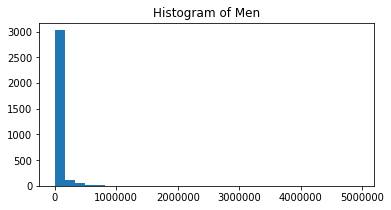

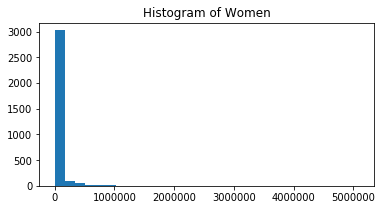

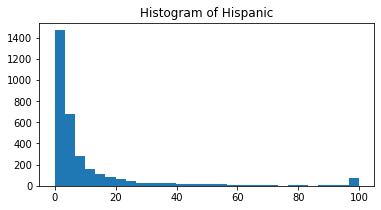

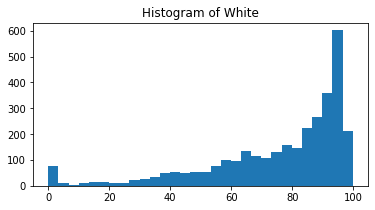

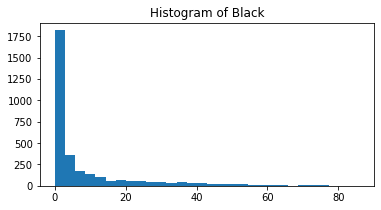

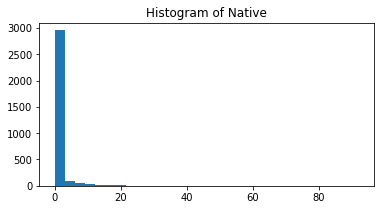

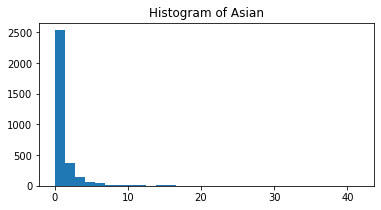

In [11]:
# Definition of histograms to be generated
columns_to_hist = ['Men', 'Women', 'Hispanic', 'White', 'Black', 'Native', 'Asian']
n_bins = 30


for column_name in columns_to_hist:
    ax=plt.subplots(figsize=(6,3))
    # get data by column_name and display a histogram
    ax = plt.hist(clean_counties_df[column_name], bins=n_bins)
    title=f"Histogram of {column_name}"
    plt.title(title, fontsize=12)
    plt.show()


## Data normalization (Pre-training)

Since the dataset columns present distinct range of values, at different scales, I use an MinMaxScaler to standardize numerical values.

In [12]:
from sklearn.preprocessing import MinMaxScaler
# scale numerical features into a normalized range, 0-1
# store them in this dataframe
counties_scaled = clean_counties_df.copy()
for column in counties_scaled:
    counties_scaled[[column]] = MinMaxScaler().fit_transform(clean_counties_df[[column]])
    
counties_scaled.describe()

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
count,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,...,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000,3218.000000
mean,0.009883,0.009866,0.009899,0.110170,0.756024,0.100942,0.018682,0.029405,0.006470,0.011540,...,0.046496,0.041154,0.124428,0.470140,0.009806,0.760810,0.194426,0.216744,0.029417,0.221775
std,0.031818,0.031692,0.031948,0.192617,0.229682,0.166262,0.078748,0.062744,0.035446,0.033933,...,0.051956,0.042321,0.085301,0.143135,0.032305,0.132949,0.106923,0.106947,0.046451,0.112138
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001092,0.001117,0.001069,0.019019,0.642285,0.005821,0.001086,0.004808,0.000000,0.001371,...,0.019663,0.023018,0.072581,0.373402,0.000948,0.697279,0.120861,0.147541,0.010204,0.150685
50%,0.002571,0.002591,0.002539,0.039039,0.842685,0.022119,0.003257,0.012019,0.000000,0.003219,...,0.033708,0.033248,0.104839,0.462916,0.002234,0.785714,0.172185,0.188525,0.020408,0.208219
75%,0.006594,0.006645,0.006556,0.098098,0.933868,0.111758,0.006515,0.028846,0.000000,0.008237,...,0.056180,0.048593,0.150538,0.560102,0.006144,0.853741,0.243377,0.256831,0.030612,0.271233
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Get session, IAM role and bucket

In [13]:
session = sagemaker.Session() # SageMaker session

role = sagemaker.get_execution_role() # IAM role for this session

bucket_name = session.default_bucket() # Bucket

## Principal Component Analysis

In [14]:
# define a folder name for this job's results
prefix = 'counties'
# Output path in S3
output_path=f's3://{bucket_name}/{prefix}/'

In [15]:
# define a PCA model
from sagemaker import PCA

N_COMPONENTS=33

pca_estimator = PCA(role=role,
             train_instance_count=1,
             train_instance_type='ml.c4.xlarge',
             output_path=output_path,
             num_components=N_COMPONENTS, 
             sagemaker_session=session)

In [16]:
# Prepare RecordSet (required by SageMaker PCA Model)

train_data_np = counties_scaled.values.astype('float32')

formatted_train_data = pca_estimator.record_set(train_data_np)

In [18]:
# Train model
pca_estimator.fit(formatted_train_data)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-11-18 21:57:49 Starting - Starting the training job...
2020-11-18 21:57:53 Starting - Launching requested ML instances......
2020-11-18 21:59:07 Starting - Preparing the instances for training.........
2020-11-18 22:00:42 Downloading - Downloading input data
2020-11-18 22:00:42 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/18/2020 22:01:05 INFO 140227901974336] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[11/18/2020 22:01:05 INFO 140227901974336] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'34', u'mini_batch_size': u'500', u'num_comp

In [22]:
# Retrieve job results from S3
pca_job_name = 'pca-2020-11-18-21-57-49-596'

path_to_model = os.path.join(prefix, pca_job_name, 'output/model.tar.gz')

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(path_to_model, 'model.tar.gz')
# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

2304

In [23]:
# Load MXNet model artifacts into a local MXNet
import mxnet as mx

pca_params = mx.ndarray.load('model_algo-1')

### PCA Attributes

Three types of model attributes are contained within the PCA model.

- `mean`: The mean that was subtracted from a component in order to center it.
- `v`: The makeup of the principal components; (same as ‘components_’ in an sklearn PCA model).
- `s`: The singular values of the components for the PCA transformation. This does not exactly give the % variance from the original feature space, but can give the % variance from the projected feature space.

We are only interested in `v` and `s`.

In [24]:
# Get the necessary attributes

pca_v = pd.DataFrame(pca_params['v'].asnumpy())
pca_s = pd.DataFrame(pca_params['s'].asnumpy())

In [25]:
# The components are ordered in ascending order of s
print(pca_s)

            0
0    0.017896
1    0.030864
2    0.032131
3    0.035486
4    0.094832
5    0.126994
6    0.402887
7    1.408476
8    1.510049
9    1.595794
10   1.778376
11   2.166252
12   2.296636
13   2.385605
14   2.695488
15   2.806798
16   3.017596
17   3.395267
18   3.573130
19   3.696696
20   4.189021
21   4.345750
22   4.541038
23   5.018966
24   5.578647
25   5.980970
26   6.392514
27   7.695221
28   7.991313
29  10.180052
30  11.718245
31  13.035975
32  19.592180


### Dimensionality and Variance
I want to keep the `n` most important features so that they totalize at least 80% of the original variance. Hopefully, a much smaller number of features will be necessary to cover most of the data variance, and those are the components to be picked in order to reduce the model dimensionality.

The variance of a set of `n` components is given as:

\begin{equation}
\frac{\sum_{i}^{n} {s_i}^2}{\sum s^2}
\end{equation}

In [26]:
# Calculate the explained variance for the top n principal components
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    s2 = s * s
    last_n_variance = s2.iloc[-n_top_components:].sum()[0]
    total_variance = s2.iloc[:].sum()[0]
    
    return last_n_variance/total_variance

In [28]:
### Testing 
n_top_components = 7 # select a value for the number of top components

# calculate the explained variance
exp_variance = explained_variance(pca_s, n_top_components)
print('Explained variance: ', exp_variance)

Explained variance:  0.80167246


### Composition of PCA components


In [29]:
import seaborn as sns

def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()


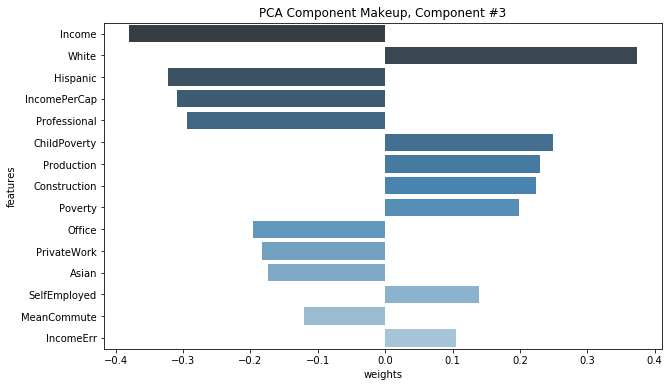

In [36]:
# Show composition of a given component
num=3
display_component(pca_v, counties_scaled.columns.values, component_num=num, n_weights=15)

## Deploying PCA to evaluate dataset



In [39]:
pca_predictor = pca_estimator.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!

We can pass the original, numpy dataset to the model and transform the data using the model we created. Then we can take the largest n components to reduce the dimensionality of our data.

In [40]:
# pass np train data to the PCA model
train_pca = pca_predictor.predict(train_data_np)

In [41]:
# create dimensionality-reduced data
def create_transformed_df(train_pca, counties_scaled, n_top_components):
    ''' Return a dataframe of data points with component features. 
        The dataframe should be indexed by State-County and contain component values.
        :param train_pca: A list of pca training data, returned by a PCA model.
        :param counties_scaled: A dataframe of normalized, original features.
        :param n_top_components: An integer, the number of top components to use.
        :return: A dataframe, indexed by State-County, with n_top_component values as columns.        
     '''
    # create a dataframe of component features, indexed by State-County
    new_df = pd.DataFrame()
    
    # your code here
    for row in range(len(train_pca)):
        for col in range(n_top_components):
            new_df.loc[counties_scaled.index[row], f'c_{col+1}'] = train_pca[row].label['projection'].float32_tensor.values[-col-1]
    
    return new_df

In [42]:
## Specify top n
top_n = n_top_components

# call your function and create a new dataframe
counties_transformed = create_transformed_df(train_pca, counties_scaled, n_top_components=top_n)

# print result
counties_transformed.head()

,c_1,c_2,c_3,c_4,c_5,c_6,c_7
Alabama-Autauga,-0.060274,0.160527,-0.088356,0.120480,-0.010824,0.040452,0.025895
Alabama-Baldwin,-0.149684,0.185969,-0.145743,-0.023092,-0.068677,0.051573,0.048137
Alabama-Barbour,0.506202,0.296662,0.146258,0.297829,0.093111,-0.065244,0.107730
Alabama-Bibb,0.069224,0.190861,0.224402,0.011757,0.283526,0.017874,-0.092053
Alabama-Blount,-0.091030,0.254403,0.022714,-0.193824,0.100738,0.209945,-0.005099


### Delete PCA endpoint


In [43]:
# delete predictor endpoint
session.delete_endpoint(pca_predictor.endpoint)

---
## Population Segmentation

The transformed model now should be used to feed our unsupervised learning model. 
For the clusterization, I'll apply the `K-means` clusterization.

In [45]:
# define a KMeans estimator
from sagemaker import KMeans
estimator = KMeans(
    role, 
    train_instance_count=1, 
    train_instance_type='ml.c4.xlarge', 
    k=8,
    sagemaker_session=session, 
    output_path=output_path)

In [46]:
# Create RecordSet

train_data_np = counties_transformed.values.astype('float32')

# convert to RecordSet format
train_data_rs = estimator.record_set(train_data_np)

In [47]:
# Train model
estimator.fit(records=train_data_rs, wait=True)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-11-18 22:26:06 Starting - Starting the training job...
2020-11-18 22:26:11 Starting - Launching requested ML instances.........
2020-11-18 22:27:45 Starting - Preparing the instances for training.........
2020-11-18 22:29:29 Downloading - Downloading input data
2020-11-18 22:29:29 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[11/18/2020 22:29:53 INFO 140491134924608] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', 

In [48]:
# Deploy model
kmeans_predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!

In [49]:
# get the predicted clusters for all the kmeans training data
cluster_info = kmeans_predictor.predict(train_data_np)

## Exploring clusters

In [50]:
# print cluster info for a given data point
data_idx = 100

print('County is: ', counties_transformed.index[data_idx])
print()
print(cluster_info[data_idx])

County is:  Arizona-Graham

label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 6.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 0.3201510012149811
    }
  }
}



### Distribution of data over clusters


In [51]:
# get all cluster labels
cluster_labels = [c.label['closest_cluster'].float32_tensor.values[0] for c in cluster_info]

# count up the points in each cluster
cluster_df = pd.DataFrame(cluster_labels)[0].value_counts()

print(cluster_df)

2.0    908
0.0    723
3.0    390
4.0    369
5.0    348
7.0    215
6.0    176
1.0     89
Name: 0, dtype: int64


In [52]:
# Delete endpoint
session.delete_endpoint(kmeans_predictor.endpoint)

---
# Model Attributes and Explainability

Explaining the result of the modeling is an important step in making use of our analysis. By combining PCA and k-means, and the information contained in the model attributes within a SageMaker trained model, we can learn about a population and remark on some patterns we've found, based on the data.

In [53]:
# download and unzip the kmeans model file
training_job_name='kmeans-2020-11-18-22-26-06-532'

# where the model is saved, by default
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

# download and unzip model
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')

# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

counties/kmeans-2020-11-18-22-26-06-532/output/model.tar.gz


2304

In [54]:
# get the trained kmeans params using mxnet
kmeans_model_params = mx.ndarray.load('model_algo-1')

# what are the params
print(kmeans_model_params)

[
[[-0.02581199  0.11517721  0.14500658 -0.08278676 -0.00975357  0.07453791
  -0.03125909]
 [ 1.3215716  -0.21476468 -0.1786174  -0.4333747  -0.1316069   0.12624055
   0.17695472]
 [-0.22125205  0.05834187 -0.01045534 -0.06544383 -0.03754815 -0.03233656
  -0.00481136]
 [ 0.34284386  0.24035561  0.06889755  0.2435841   0.09005872 -0.06023351
   0.04408429]
 [-0.26010478 -0.32332093  0.07575368  0.05370796  0.05569805 -0.03061409
   0.06393785]
 [-0.09071302  0.06618641 -0.3985669   0.08543926  0.00559547  0.08878476
  -0.00508527]
 [ 0.40576458 -0.21290216 -0.14805165 -0.20847136  0.1319799  -0.14800316
  -0.08981948]
 [ 0.15572166 -0.26298735  0.10831264  0.12433596 -0.10333203  0.01101648
  -0.05983399]]
<NDArray 8x7 @cpu(0)>]


There is only 1 set of model parameters contained within the k-means model: the cluster centroid locations in PCA-transformed, component space.

- **centroids**: The location of the centers of each cluster in component space, identified by the k-means algorithm.

In [55]:
# get all the centroids
cluster_centroids=pd.DataFrame(kmeans_model_params[0].asnumpy())
cluster_centroids.columns=counties_transformed.columns

display(cluster_centroids)

,c_1,c_2,c_3,c_4,c_5,c_6,c_7
0,-0.025812,0.115177,0.145007,-0.082787,-0.009754,0.074538,-0.031259
1,1.321572,-0.214765,-0.178617,-0.433375,-0.131607,0.126241,0.176955
2,-0.221252,0.058342,-0.010455,-0.065444,-0.037548,-0.032337,-0.004811
3,0.342844,0.240356,0.068898,0.243584,0.090059,-0.060234,0.044084
4,-0.260105,-0.323321,0.075754,0.053708,0.055698,-0.030614,0.063938
5,-0.090713,0.066186,-0.398567,0.085439,0.005595,0.088785,-0.005085
6,0.405765,-0.212902,-0.148052,-0.208471,0.131980,-0.148003,-0.089819
7,0.155722,-0.262987,0.108313,0.124336,-0.103332,0.011016,-0.059834


### Visualization of Centroids

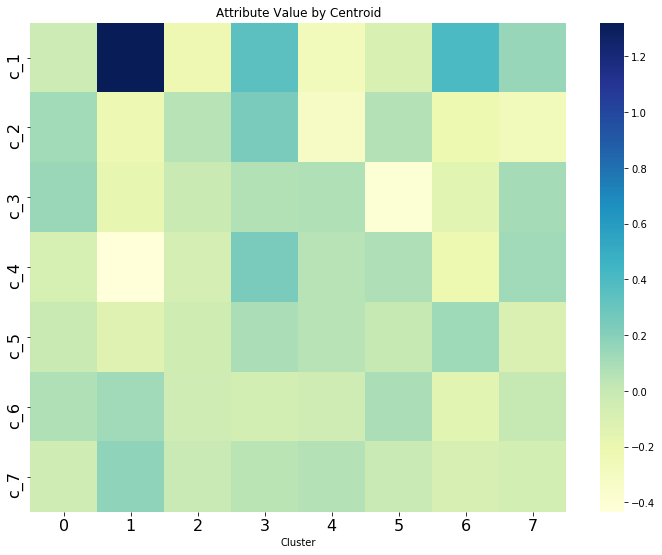

In [56]:
# generate a heatmap in component space, using the seaborn library
plt.figure(figsize = (12,9))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

### Natural Groupings

In [57]:
# add a 'labels' column to the dataframe
counties_transformed['labels']=list(map(int, cluster_labels))

# sort by cluster label 0-6
sorted_counties = counties_transformed.sort_values('labels', ascending=True)
# view some pts in cluster 0
sorted_counties.head(20)

,c_1,c_2,c_3,c_4,c_5,c_6,c_7,labels
Pennsylvania-Fulton,-0.235782,0.145364,0.117231,-0.129777,0.141751,0.172668,-0.142452,0
Georgia-Lumpkin,-0.124563,0.051265,0.035631,-0.039928,-0.101739,0.176969,0.080302,0
Texas-Burleson,0.113557,-0.035419,-0.008676,-0.015108,0.191116,0.072753,-0.024934,0
North Carolina-Alleghany,-0.024880,-0.058949,0.176142,-0.057248,-0.021611,0.140103,0.047889,0
North Carolina-Ashe,-0.057906,0.031238,0.234711,-0.122242,0.004603,0.142519,-0.022430,0
Georgia-Madison,-0.070352,0.107618,0.067423,-0.022931,0.011536,0.078947,0.079553,0
Texas-Bosque,-0.046639,-0.021682,0.020063,-0.143669,0.140769,0.125623,-0.010576,0
North Carolina-Avery,-0.112962,-0.005821,0.102811,-0.045867,-0.052617,0.020158,-0.063649,0
North Carolina-Brunswick,-0.019961,0.103189,0.001164,0.003535,-0.056454,0.049040,-0.052446,0
Texas-Burnet,-0.001310,-0.103779,-0.037240,-0.113198,0.067212,0.058054,0.021098,0


---
## Empty bucket  

In [68]:
bucket_uri = f's3://{bucket_name}'
!aws s3 rm $bucket_uri --recursive